<a href="https://colab.research.google.com/github/Jgallear/CSSP_brazil_23_24/blob/main/sequential_VHI_cluster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# spatial cluster VHI from 10 to 1 then measure the average variance in each cluster
!pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 69.9 MB/s eta 0:00:00


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from mpl_toolkits.axes_grid1 import make_axes_locatable
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from shapely.geometry import mapping
import cartopy.crs as ccrs
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
from sklearn.inspection import PartialDependenceDisplay
from shapely.geometry import Point
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from cartopy.feature import ShapelyFeature
from cartopy.io.shapereader import Reader
#from rasterio import CRS
from shapely.geometry import mapping
import xarray as xr
from statsmodels.graphics.tsaplots import plot_acf
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge
import functools
import pickle
import cartopy.feature as cf
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
import seaborn as sns
from sklearn.metrics import mean_absolute_error
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import tensorflow as tf
import itertools
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/VHI_spei_rzsm_dataset.csv')
print(df)

           lon     lat      vhi-1   precip-1      rzsm-1  spei1-1m  spei2-1m  \
0      -53.375 -32.125  70.414172  259.20056   98.021910  2.192168  1.313241   
1      -53.375 -32.125  79.323750  146.58607   98.162980  1.228278  2.453098   
2      -53.375 -32.125  77.111895  184.82845   97.594270  1.472914  1.588110   
3      -53.375 -32.125  64.150561  108.86273   97.605330  1.680747  1.751371   
4      -53.375 -32.125  54.270359  145.90760  100.000000  1.641170  1.900034   
...        ...     ...        ...        ...         ...       ...       ...   
577682 -47.625  -0.875  41.102345  170.38158   66.929490  0.324701  0.572972   
577683 -47.625  -0.875  49.922513  294.35620   80.138200  1.130223  0.881931   
577684 -47.625  -0.875  52.101102  125.48111   88.888840  2.664571  2.250521   
577685 -47.625  -0.875  46.753572   24.13338   77.834076  2.523025  3.002636   
577686 -47.625  -0.875  48.627606   71.58264   69.860950  1.286047  2.275886   

        spei3-1m   spi01-1   spi02-1   

In [ ]:
av_df = df.groupby(['lat','lon']).mean()
av_df.reset_index(inplace=True)
print(av_df)

         lat     lon      vhi-1    precip-1     rzsm-1  spei1-1m  spei2-1m  \
0    -32.125 -53.375  50.641490  119.583238  51.176756  0.025127  0.075895   
1    -31.875 -53.375  51.297176  123.557941  50.933692  0.025127  0.075895   
2    -31.875 -53.125  50.021865  121.459614  47.052244  0.025127  0.075895   
3    -31.875 -52.875  47.316135  119.407411  54.085003  0.042004  0.094313   
4    -31.875 -52.625  47.356915  120.290862  55.073166  0.050814  0.101828   
...      ...     ...        ...         ...        ...       ...       ...   
2492  -1.125 -48.125  45.059091  255.130677  59.221819 -0.068908 -0.055040   
2493  -1.125 -47.875  43.319721  247.737871  57.681992 -0.075719 -0.057787   
2494  -1.125 -47.625  42.088392  240.408432  55.171777 -0.087014 -0.067747   
2495  -1.125 -47.375  41.638401  235.323676  55.560596 -0.091299 -0.071796   
2496  -0.875 -47.625  43.420835  256.814819  54.582120 -0.092605 -0.071670   

      spei3-1m   spi01-1   spi02-1   spi03-1     pev-1   longra

In [ ]:
def get_cluster_df(df,col_name,new_name):
  return pd.DataFrame({'lat':df['lat'],'lon':df['lon'],new_name:df[col_name]})

In [ ]:
vhi_df = get_cluster_df(av_df,'vhi-1','VHI')

In [ ]:
scaler = MinMaxScaler()
VHI_df_scaled = scaler.fit_transform(vhi_df)

In [ ]:
def groupby_cluster(df):
  df_list=[]
  for index,df in df.groupby(['cluster']):
    df_list.append(df)
  return df_list

In [ ]:
# fit k means clustering in a loop, from 1 to 10
def loop_cluster(data,max_cluster_no,r_data): # scaled data, max number of clusters, raw unscaled data
  variances_list = []
  cluster_numbers=[]
  cluster_size_list=[]
  cluster_df_list=[]
  for i in np.arange(max_cluster_no):
    #print(i+1)
    KMi = KMeans(n_clusters=i+1)
    KMi.fit(data)
    clustersi_VHI = KMi.predict(data)
    # Need to measure the average variance within each cluster
    # add cluster number onto dataframe
    r_data_copyi = r_data.copy()
    r_data_copyi['cluster'] = clustersi_VHI
    print(r_data_copyi)
    cluster_df_list.append(r_data_copyi)
    # need to groupby cluster then get variances, then average
    data_listi = groupby_cluster(r_data_copyi)
    print(len(data_listi))
    # get variance for VHI column
    ij_variances=[]
    cluster_sizes=[]
    for j in range(len(data_listi)):
      vari = np.var(data_listi[j]['VHI'])

      ij_variances.append(vari)
      # cluster size
      cl_size = len(data_listi[j]['VHI'])
      cluster_sizes.append(cl_size)
    ###
    # get average variance across clusters
    cluster_size_list.append(np.mean(cluster_sizes))
    variances_i = np.mean(ij_variances)
    variances_list.append(variances_i)
    cluster_numbers.append(i+1)
  return variances_list, cluster_numbers, cluster_size_list, cluster_df_list

In [ ]:
variances, cl_numbers, cluster_sizes, cluster_df_list = loop_cluster(VHI_df_scaled,10,vhi_df)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        0
1    -31.875 -53.375  51.297176        0
2    -31.875 -53.125  50.021865        0
3    -31.875 -52.875  47.316135        0
4    -31.875 -52.625  47.356915        0
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        0
2493  -1.125 -47.875  43.319721        0
2494  -1.125 -47.625  42.088392        0
2495  -1.125 -47.375  41.638401        0
2496  -0.875 -47.625  43.420835        0

[2497 rows x 4 columns]
1


<ipython-input-8-da07240c5b06>:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for index,df in df.groupby(['cluster']):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        0
1    -31.875 -53.375  51.297176        0
2    -31.875 -53.125  50.021865        0
3    -31.875 -52.875  47.316135        0
4    -31.875 -52.625  47.356915        0
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        1
2493  -1.125 -47.875  43.319721        1
2494  -1.125 -47.625  42.088392        1
2495  -1.125 -47.375  41.638401        1
2496  -0.875 -47.625  43.420835        1

[2497 rows x 4 columns]
2


<ipython-input-8-da07240c5b06>:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for index,df in df.groupby(['cluster']):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        2
1    -31.875 -53.375  51.297176        2
2    -31.875 -53.125  50.021865        2
3    -31.875 -52.875  47.316135        2
4    -31.875 -52.625  47.356915        2
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        1
2493  -1.125 -47.875  43.319721        1
2494  -1.125 -47.625  42.088392        1
2495  -1.125 -47.375  41.638401        1
2496  -0.875 -47.625  43.420835        1

[2497 rows x 4 columns]
3


<ipython-input-8-da07240c5b06>:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for index,df in df.groupby(['cluster']):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        0
1    -31.875 -53.375  51.297176        0
2    -31.875 -53.125  50.021865        0
3    -31.875 -52.875  47.316135        0
4    -31.875 -52.625  47.356915        0
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        2
2493  -1.125 -47.875  43.319721        2
2494  -1.125 -47.625  42.088392        2
2495  -1.125 -47.375  41.638401        2
2496  -0.875 -47.625  43.420835        2

[2497 rows x 4 columns]
4


<ipython-input-8-da07240c5b06>:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for index,df in df.groupby(['cluster']):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        3
1    -31.875 -53.375  51.297176        3
2    -31.875 -53.125  50.021865        3
3    -31.875 -52.875  47.316135        3
4    -31.875 -52.625  47.356915        3
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        4
2493  -1.125 -47.875  43.319721        4
2494  -1.125 -47.625  42.088392        4
2495  -1.125 -47.375  41.638401        4
2496  -0.875 -47.625  43.420835        4

[2497 rows x 4 columns]
5


<ipython-input-8-da07240c5b06>:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for index,df in df.groupby(['cluster']):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        2
1    -31.875 -53.375  51.297176        2
2    -31.875 -53.125  50.021865        2
3    -31.875 -52.875  47.316135        2
4    -31.875 -52.625  47.356915        2
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        3
2493  -1.125 -47.875  43.319721        3
2494  -1.125 -47.625  42.088392        3
2495  -1.125 -47.375  41.638401        3
2496  -0.875 -47.625  43.420835        3

[2497 rows x 4 columns]
6
         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        2
1    -31.875 -53.375  51.297176        2
2    -31.875 -53.125  50.021865        2
3    -31.875 -52.875  47.316135        2
4    -31.875 -52.625  47.356915        2
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        1
2493  -1.125 -47.875  43.319721        1
2494  -1.125 -47.625  42.088392        1
2495  -1.125 -47.375  41.638401        1
2496  -0.875 -47.625  43.42083

<ipython-input-8-da07240c5b06>:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for index,df in df.groupby(['cluster']):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-8-da07240c5b06>:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for index,df in df.groupby(['cluster']):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_

         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        4
1    -31.875 -53.375  51.297176        4
2    -31.875 -53.125  50.021865        4
3    -31.875 -52.875  47.316135        4
4    -31.875 -52.625  47.356915        4
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        7
2493  -1.125 -47.875  43.319721        7
2494  -1.125 -47.625  42.088392        7
2495  -1.125 -47.375  41.638401        7
2496  -0.875 -47.625  43.420835        7

[2497 rows x 4 columns]
9
         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        2
1    -31.875 -53.375  51.297176        2
2    -31.875 -53.125  50.021865        2
3    -31.875 -52.875  47.316135        2
4    -31.875 -52.625  47.356915        2
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        5
2493  -1.125 -47.875  43.319721        5
2494  -1.125 -47.625  42.088392        5
2495  -1.125 -47.375  41.638401        5
2496  -0.875 -47.625  43.42083

<ipython-input-8-da07240c5b06>:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for index,df in df.groupby(['cluster']):
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
<ipython-input-8-da07240c5b06>:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for index,df in df.groupby(['cluster']):


In [ ]:
print(variances)

[22.117037613076036, 12.674702114381102, 12.364256243683807, 10.304046703679832, 7.994554200390601, 6.887599690705026, 7.8862908060445545, 6.744204509712114, 6.102565872798556, 5.759028411217441]


In [ ]:
print(cluster_sizes)

[2497.0, 1248.5, 832.3333333333334, 624.25, 499.4, 416.1666666666667, 356.7142857142857, 312.125, 277.44444444444446, 249.7]


In [ ]:
print(cl_numbers)

[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]


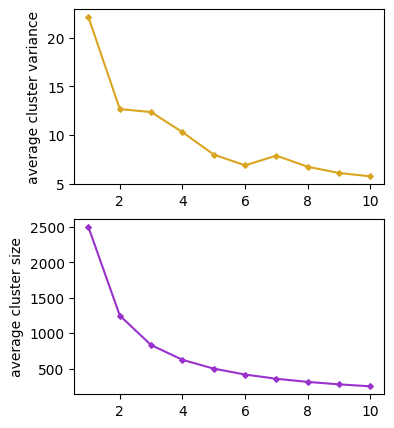

In [ ]:
fig = plt.figure(figsize=(4,5))
ax=fig.add_subplot(2,1,1)
ax.plot(cl_numbers,variances,c='goldenrod')
ax.scatter(cl_numbers,variances,c='goldenrod',marker='D',s=8)
ax.set_ylabel('average cluster variance')
ax=fig.add_subplot(2,1,2)
ax.plot(cl_numbers,cluster_sizes,c='darkorchid')
ax.scatter(cl_numbers,cluster_sizes,c='darkorchid',marker='D',s=8)
ax.set_ylabel('average cluster size')
plt.show()

In [ ]:
# Need to plot each set of clusters as map
fname = '/content/drive/MyDrive/shapefiles/BR/BR_EST_SAD69.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(),
                                ccrs.PlateCarree(), facecolor='none')

In [ ]:
print(len(cluster_df_list))

10


In [ ]:
print(cluster_df_list[0])
print(cluster_df_list[1])

         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        0
1    -31.875 -53.375  51.297176        0
2    -31.875 -53.125  50.021865        0
3    -31.875 -52.875  47.316135        0
4    -31.875 -52.625  47.356915        0
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        0
2493  -1.125 -47.875  43.319721        0
2494  -1.125 -47.625  42.088392        0
2495  -1.125 -47.375  41.638401        0
2496  -0.875 -47.625  43.420835        0

[2497 rows x 4 columns]
         lat     lon        VHI  cluster
0    -32.125 -53.375  50.641490        0
1    -31.875 -53.375  51.297176        0
2    -31.875 -53.125  50.021865        0
3    -31.875 -52.875  47.316135        0
4    -31.875 -52.625  47.356915        0
...      ...     ...        ...      ...
2492  -1.125 -48.125  45.059091        1
2493  -1.125 -47.875  43.319721        1
2494  -1.125 -47.625  42.088392        1
2495  -1.125 -47.375  41.638401        1
2496  -0.875 -47.625  43.420835 

In [ ]:
xt = np.linspace(np.min(cluster_df_list[0]['lon']),np.max(cluster_df_list[0]['lon']),5)
xt = np.round(xt,decimals=0)

yt = np.linspace(np.min(cluster_df_list[0]['lat']),np.max(cluster_df_list[0]['lat']),5)
yt = np.round(yt,decimals=0)

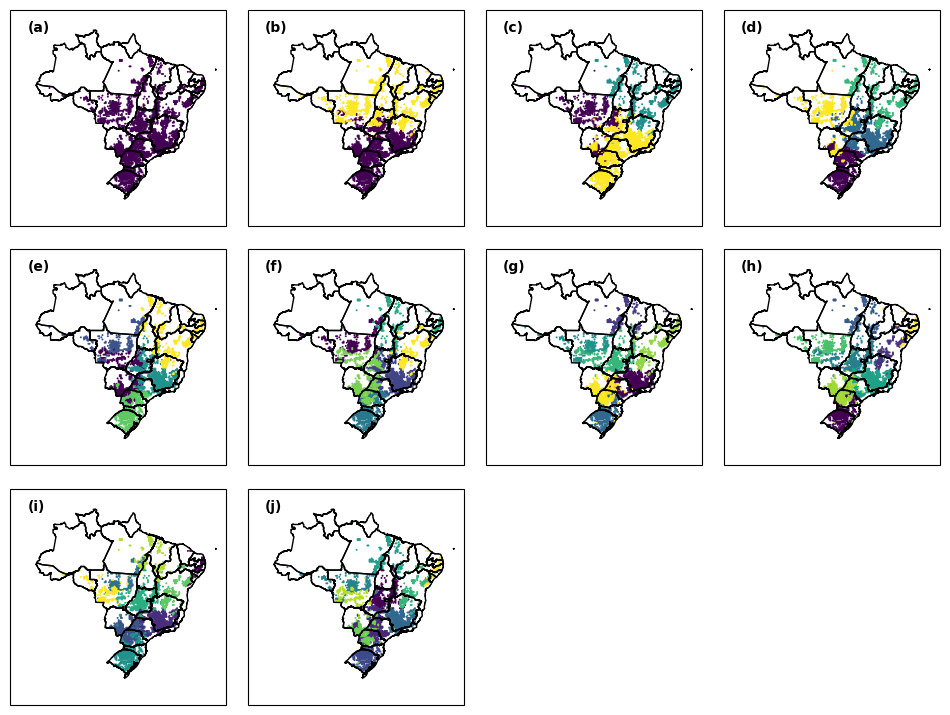

In [ ]:
fig = plt.figure(figsize=(12,14))
ax=fig.add_subplot(3,4,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[0]['cluster'].min(), cluster_df_list[0]['cluster'].max())
for i, dff in cluster_df_list[0].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.set_title('1 cluster')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
#ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(a)',weight='bold',fontsize=10)
#############################################################
ax=fig.add_subplot(3,4,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[1]['cluster'].min(), cluster_df_list[1]['cluster'].max())
for i, dff in cluster_df_list[1].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('2 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
#ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(b)',weight='bold',fontsize=10)
###############################################################
ax=fig.add_subplot(3,4,3,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[2]['cluster'].min(), cluster_df_list[2]['cluster'].max())
for i, dff in cluster_df_list[2].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('3 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
#ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(c)',weight='bold',fontsize=10)
############################################################
ax=fig.add_subplot(3,4,4,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[3]['cluster'].min(), cluster_df_list[3]['cluster'].max())
for i, dff in cluster_df_list[3].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('4 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
#ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(d)',weight='bold',fontsize=10)
#########################################################################
ax=fig.add_subplot(3,4,5,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[4]['cluster'].min(), cluster_df_list[4]['cluster'].max())
for i, dff in cluster_df_list[4].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('5 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
#ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(e)',weight='bold',fontsize=10)
###########################################################################
ax=fig.add_subplot(3,4,6,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[5]['cluster'].min(), cluster_df_list[5]['cluster'].max())
for i, dff in cluster_df_list[5].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('6 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
#ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(f)',weight='bold',fontsize=10)
############################################################################
ax=fig.add_subplot(3,4,7,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[6]['cluster'].min(), cluster_df_list[6]['cluster'].max())
for i, dff in cluster_df_list[6].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('7 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
#ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(g)',weight='bold',fontsize=10)
############################################################################
ax=fig.add_subplot(3,4,8,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[7]['cluster'].min(), cluster_df_list[7]['cluster'].max())
for i, dff in cluster_df_list[7].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('8 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
#ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(h)',weight='bold',fontsize=10)
#################################################################################
ax=fig.add_subplot(3,4,9,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[8]['cluster'].min(), cluster_df_list[8]['cluster'].max())
for i, dff in cluster_df_list[8].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('9 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
#ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(i)',weight='bold',fontsize=10)
#plt.subplots_adjust(wspace=0, hspace=-0.2)
##############################################################################
ax=fig.add_subplot(3,4,10,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[9]['cluster'].min(), cluster_df_list[9]['cluster'].max())
for i, dff in cluster_df_list[9].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('10 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
#ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(j)',weight='bold',fontsize=10)


plt.subplots_adjust(wspace=0.1, hspace=-0.6)


plt.savefig('/content/drive/MyDrive/Figures/sequential_cluster_maps.png',dpi=300)
plt.show()

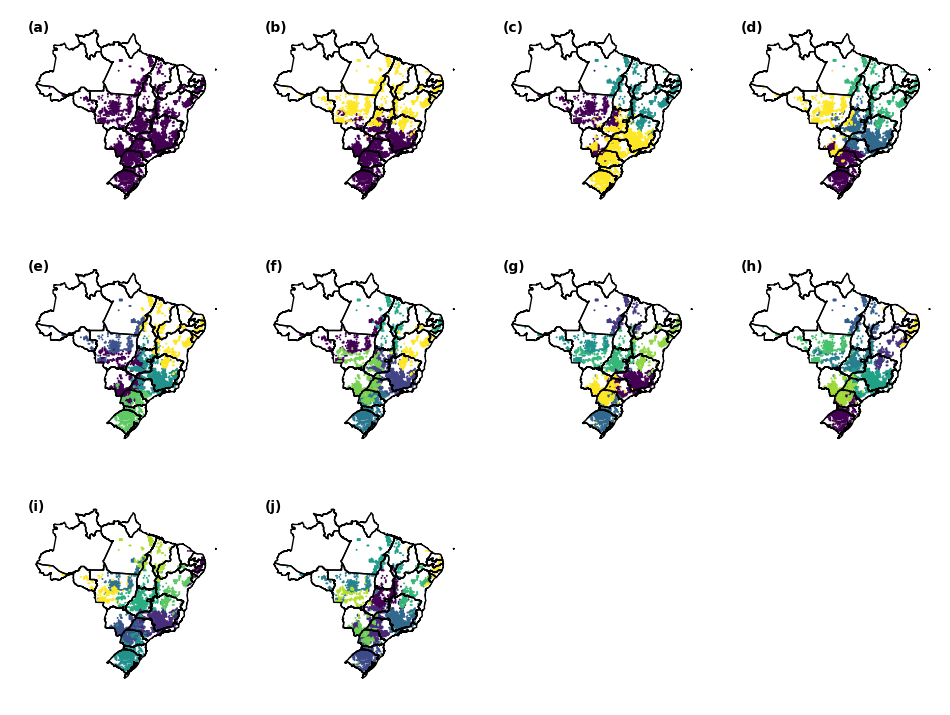

In [ ]:
fig = plt.figure(figsize=(12,14))
ax=fig.add_subplot(3,4,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[0]['cluster'].min(), cluster_df_list[0]['cluster'].max())
for i, dff in cluster_df_list[0].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.set_title('1 cluster')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(a)',weight='bold',fontsize=10)
#############################################################
ax=fig.add_subplot(3,4,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[1]['cluster'].min(), cluster_df_list[1]['cluster'].max())
for i, dff in cluster_df_list[1].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('2 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(b)',weight='bold',fontsize=10)
###############################################################
ax=fig.add_subplot(3,4,3,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[2]['cluster'].min(), cluster_df_list[2]['cluster'].max())
for i, dff in cluster_df_list[2].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('3 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(c)',weight='bold',fontsize=10)
############################################################
ax=fig.add_subplot(3,4,4,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[3]['cluster'].min(), cluster_df_list[3]['cluster'].max())
for i, dff in cluster_df_list[3].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('4 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(d)',weight='bold',fontsize=10)
#########################################################################
ax=fig.add_subplot(3,4,5,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[4]['cluster'].min(), cluster_df_list[4]['cluster'].max())
for i, dff in cluster_df_list[4].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('5 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(e)',weight='bold',fontsize=10)
###########################################################################
ax=fig.add_subplot(3,4,6,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[5]['cluster'].min(), cluster_df_list[5]['cluster'].max())
for i, dff in cluster_df_list[5].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('6 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(f)',weight='bold',fontsize=10)
############################################################################
ax=fig.add_subplot(3,4,7,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[6]['cluster'].min(), cluster_df_list[6]['cluster'].max())
for i, dff in cluster_df_list[6].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('7 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(g)',weight='bold',fontsize=10)
############################################################################
ax=fig.add_subplot(3,4,8,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[7]['cluster'].min(), cluster_df_list[7]['cluster'].max())
for i, dff in cluster_df_list[7].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('8 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(h)',weight='bold',fontsize=10)
#################################################################################
ax=fig.add_subplot(3,4,9,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[8]['cluster'].min(), cluster_df_list[8]['cluster'].max())
for i, dff in cluster_df_list[8].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('9 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(i)',weight='bold',fontsize=10)
#plt.subplots_adjust(wspace=0, hspace=-0.2)
##############################################################################
ax=fig.add_subplot(3,4,10,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[9]['cluster'].min(), cluster_df_list[9]['cluster'].max())
for i, dff in cluster_df_list[9].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('10 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(j)',weight='bold',fontsize=10)


plt.subplots_adjust(wspace=0.1, hspace=-0.6)


plt.savefig('/content/drive/MyDrive/Figures/sequential_cluster_maps.png',dpi=300)
plt.show()

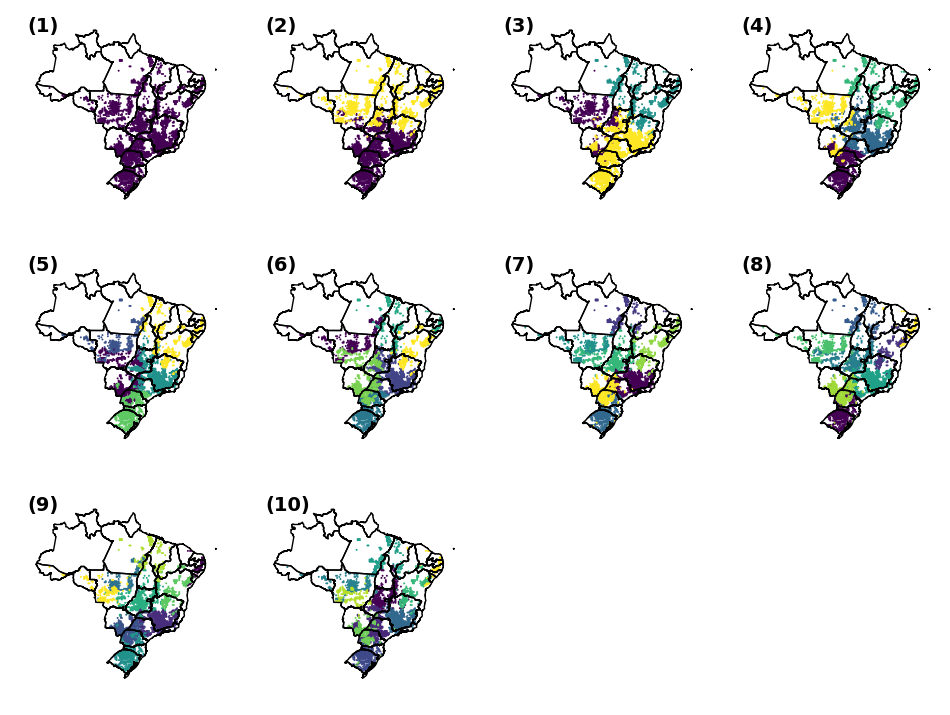

In [ ]:
fig = plt.figure(figsize=(12,14))
ax=fig.add_subplot(3,4,1,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[0]['cluster'].min(), cluster_df_list[0]['cluster'].max())
for i, dff in cluster_df_list[0].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.set_title('1 cluster')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(1)',weight='bold',fontsize=14)
#############################################################
ax=fig.add_subplot(3,4,2,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[1]['cluster'].min(), cluster_df_list[1]['cluster'].max())
for i, dff in cluster_df_list[1].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('2 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(2)',weight='bold',fontsize=14)
###############################################################
ax=fig.add_subplot(3,4,3,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[2]['cluster'].min(), cluster_df_list[2]['cluster'].max())
for i, dff in cluster_df_list[2].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('3 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(3)',weight='bold',fontsize=14)
############################################################
ax=fig.add_subplot(3,4,4,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[3]['cluster'].min(), cluster_df_list[3]['cluster'].max())
for i, dff in cluster_df_list[3].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('4 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(4)',weight='bold',fontsize=14)
#########################################################################
ax=fig.add_subplot(3,4,5,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[4]['cluster'].min(), cluster_df_list[4]['cluster'].max())
for i, dff in cluster_df_list[4].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('5 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(5)',weight='bold',fontsize=14)
###########################################################################
ax=fig.add_subplot(3,4,6,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[5]['cluster'].min(), cluster_df_list[5]['cluster'].max())
for i, dff in cluster_df_list[5].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('6 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(6)',weight='bold',fontsize=14)
############################################################################
ax=fig.add_subplot(3,4,7,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[6]['cluster'].min(), cluster_df_list[6]['cluster'].max())
for i, dff in cluster_df_list[6].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('7 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(7)',weight='bold',fontsize=14)
############################################################################
ax=fig.add_subplot(3,4,8,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[7]['cluster'].min(), cluster_df_list[7]['cluster'].max())
for i, dff in cluster_df_list[7].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('8 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(8)',weight='bold',fontsize=14)
#################################################################################
ax=fig.add_subplot(3,4,9,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[8]['cluster'].min(), cluster_df_list[8]['cluster'].max())
for i, dff in cluster_df_list[8].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('9 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(9)',weight='bold',fontsize=14)
#plt.subplots_adjust(wspace=0, hspace=-0.2)
##############################################################################
ax=fig.add_subplot(3,4,10,projection=ccrs.PlateCarree())
#ax1.coastlines()
cmap = plt.cm.viridis
norm = plt.Normalize(cluster_df_list[9]['cluster'].min(), cluster_df_list[9]['cluster'].max())
for i, dff in cluster_df_list[9].groupby("cluster"):
    plt.scatter(dff['lon'],dff['lat'], c=cmap(norm(dff['cluster'])),
                edgecolors='none', label="cluster {:g}".format(i), transform=ccrs.PlateCarree(),s=2)

#im=ax1.scatter(plot_data['lon'], plot_data['lat'], c= av_clusters, transform=ccrs.PlateCarree())
# # Set the location and size of the colorbar axes manually
#cax = fig.add_axes([]) # left, bottom, width, height
# # Add the colorbar
#divider = make_axes_locatable(ax1)
#cax = divider.append_axes("right", size="5%", pad=0.05,axes_class=plt.Axes)
#cbar = fig.colorbar(im, ax=ax1,cax=cax)
#cbar.ax.set_ylabel('Total rainfall mm',fontsize='14')
#ax.title.set_text('10 clusters')
ax.set_extent([-80, -30, -40, 10], crs=ccrs.PlateCarree())
#plt.savefig('plots/Iizumi_2020_maize_global.pdf')
#ax1.add_feature(cf.BORDERS)
#ax.legend()
ax.add_feature(shape_feature)
ax.axis('off')
#ax.set_xticks(xt)
#ax.set_xticklabels(ax.get_xticks(),rotation=50)
#ax.set_yticks(yt)
#ax.set_yticklabels(ax.get_yticks())
ax.text(np.min(xt)-5,np.max(yt)+6,s='(10)',weight='bold',fontsize=14)


plt.subplots_adjust(wspace=0.1, hspace=-0.6)


plt.savefig('/content/drive/MyDrive/Figures/sequential_cluster_maps_numbered.png',dpi=300)
plt.savefig('/content/drive/MyDrive/Figures/sequential_cluster_maps_numbered.svg')
plt.show()

In [ ]:
# pickle list for new script which will loop through and apply gradient boosting model
with open('/content/drive/MyDrive/seq_cluster_df_list.pkl', 'wb') as f:
  pickle.dump(cluster_df_list, f)

In [ ]:
### Code for postprocessing results from train on sequential clusters script ######################

In [ ]:
cluster_results_df = pd.read_csv('/content/drive/MyDrive/GBM_model_skill_vs_number_of_clusters.csv')

In [ ]:
print(cluster_results_df)

   mean rmse scores  av_mae_scores_list  mean r2 scores  number of clusters
0          7.534572            6.011386        0.565574                   1
1          7.027572            5.691500        0.592636                   2
2          7.149719            5.722622        0.543947                   3
3          7.440888            5.967128        0.517238                   4
4          7.370920            5.907291        0.495336                   5
5          7.496290            6.014716        0.447054                   6
6          7.430266            5.952504        0.437836                   7
7          7.492293            5.936754        0.444553                   8
8          7.484598            5.941686        0.411090                   9
9          7.537864            6.027534        0.406769                  10


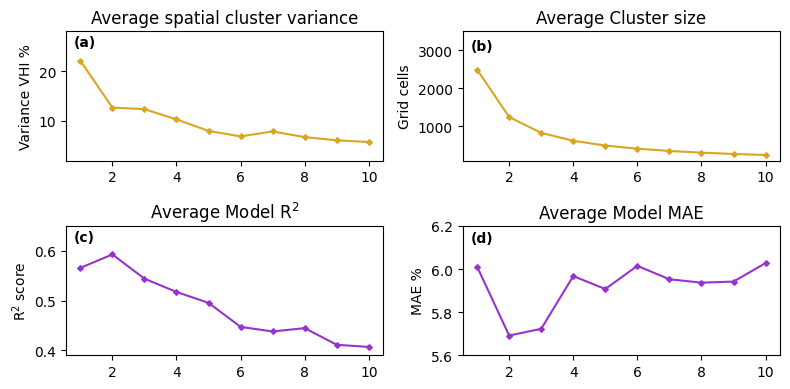

In [ ]:
fig = plt.figure(figsize=(8,4))
ax=fig.add_subplot(2,2,1)
ax.plot(cl_numbers,variances,c='goldenrod')
ax.scatter(cl_numbers,variances,c='goldenrod',marker='D',s=8)
ax.set_ylabel('Variance VHI %')
ax.set_title('Average spatial cluster variance')
ax.text(0.8,25,s='(a)',weight='bold')
ax.set_ylim(2,28)

ax=fig.add_subplot(2,2,2)
ax.plot(cl_numbers,cluster_sizes,c='goldenrod')
ax.scatter(cl_numbers,cluster_sizes,c='goldenrod',marker='D',s=8)
ax.set_ylabel('Grid cells')
#ax.set_title('(b)',loc='left')
ax.set_title('Average Cluster size')
ax.text(0.8,3000,s='(b)',weight='bold')
ax.set_ylim(100,3500)

ax=fig.add_subplot(2,2,3)
ax.plot(cluster_results_df['number of clusters'],cluster_results_df['mean r2 scores'],c='darkorchid')
ax.scatter(cluster_results_df['number of clusters'],cluster_results_df['mean r2 scores'],c='darkorchid',marker='D',s=8)
ax.set_ylabel(r'R$^2$ score')
ax.set_title(r'Average Model R$^2$')
ax.text(0.8,0.620,s='(c)',weight='bold')
ax.set_ylim(0.39,0.65)


ax=fig.add_subplot(2,2,4)
ax.plot(cluster_results_df['number of clusters'],cluster_results_df['av_mae_scores_list'],c='darkorchid')
ax.scatter(cluster_results_df['number of clusters'],cluster_results_df['av_mae_scores_list'],c='darkorchid',marker='D',s=8)
ax.set_ylabel(r'MAE %')
ax.set_title(r'Average Model MAE')
ax.text(0.8,6.125,s='(d)',weight='bold')
ax.set_ylim(5.6,6.2)

plt.tight_layout()
plt.savefig('/content/drive/MyDrive/Figures/cluster_number_vs_model_skill.png',dpi=300)
plt.show()